# Raisin prediction using Bayesian Networks
FAIKR module 3 project, done by Michele Calvanese, Samuele Marino  

## Introduction
Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. 

A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.


Attribute Information:

1. Area: Gives the number of pixels within the boundaries of the raisin.
2. Perimeter: It measures the environment by calculating the distance between the boundaries of the raisin and the pixels around it.
3. MajorAxisLength: Gives the length of the main axis, which is the longest line that can be drawn on the raisin.
4. MinorAxisLength: Gives the length of the small axis, which is the shortest line that can be drawn on the raisin.
5. Eccentricity: It gives a measure of the eccentricity of the ellipse, which has the same moments as raisins.
6. ConvexArea: Gives the number of pixels of the smallest convex shell of the region formed by the raisin.
7. Extent: Gives the ratio of the region formed by the raisin to the total pixels in the bounding box.
8. Class: Kecimen and Besni raisin.

Dataset [link](https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset).

In [14]:
import pandas as pd
import numpy as np
import pgmpy
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore, BDeuScore, MaximumLikelihoodEstimator
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout


## Data cleaning and preparation

All attributes were used for making the Bayesian Network model. Before creating the model, some of the attributes need to be discretized, as the pgmpy library only works with discrete variables. 

In [15]:
path = "./Dataset/Raisin_Dataset.xlsx"
data = pd.read_excel(path)
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [16]:
data.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


Before modifying the variables, dataset is checked for the presence of N/A values.

In [17]:
data.isnull().sum()

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64

So there is no N/A values

Now we visualize of the distribution of each attributes

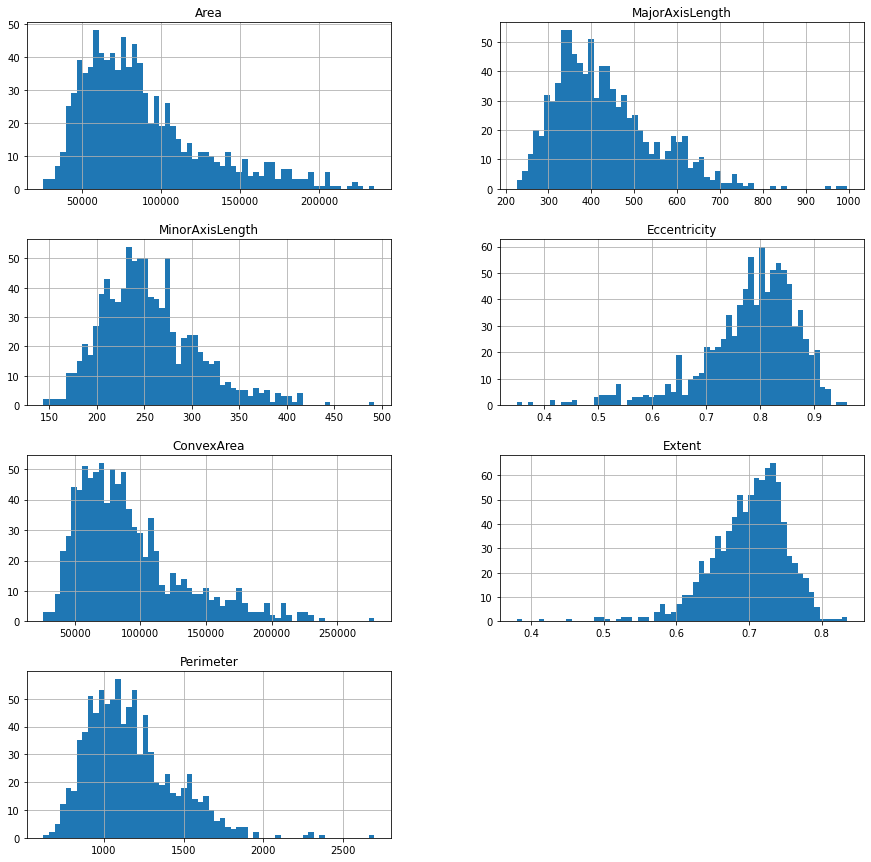

In [18]:
data.hist(layout=(4, 2), bins=60, figsize=[15, 15]);

### Variable discretization

Data need to be discretized because Pgmpy doesn't support learning parameters from continuous variables.

All attributes are discretized according to the following criteria:
- below (median - standard deviation) –> low range.
- between (median - standard deviation) and (median + standard deviation) –> medium range.
- upper (median + standard deviation) –> high range.

In [19]:
for attribute in data.columns[:-1]:

    std = data[attribute].std()
    median = data[attribute].median()
    min = data[attribute].min()
    max = data[attribute].max()

    data[attribute] = pd.cut(x=data[attribute], 
                            bins=[min, median - std, median + std, max],
                            labels=["low_range", "medium_range", "high_range"])


In [20]:
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,medium_range,medium_range,medium_range,medium_range,medium_range,medium_range,medium_range,Kecimen
1,medium_range,medium_range,medium_range,medium_range,medium_range,medium_range,medium_range,Kecimen
2,medium_range,medium_range,medium_range,medium_range,medium_range,low_range,medium_range,Kecimen
3,medium_range,low_range,medium_range,low_range,medium_range,medium_range,low_range,Kecimen
4,medium_range,medium_range,medium_range,low_range,medium_range,high_range,medium_range,Kecimen


In [21]:
data1 = data.drop('Area', axis=1)
data2 = data1.drop('ConvexArea', axis=1)
data3 = data2.drop('MajorAxisLength', axis=1)

In [22]:
data2.head()

,MajorAxisLength,MinorAxisLength,Eccentricity,Extent,Perimeter,Class
0,medium_range,medium_range,medium_range,medium_range,medium_range,Kecimen
1,medium_range,medium_range,medium_range,medium_range,medium_range,Kecimen
2,medium_range,medium_range,medium_range,low_range,medium_range,Kecimen
3,low_range,medium_range,low_range,medium_range,low_range,Kecimen
4,medium_range,medium_range,low_range,high_range,medium_range,Kecimen


In [23]:
data = data3

## B

In [24]:
#learning the stucutre of the network
est = HillClimbSearch(data)
best_model = est.estimate(scoring_method=BDeuScore(data))

  0%|          | 8/1000000 [00:00<25:47:25, 10.77it/s]


In [25]:
#the estimated model returns a DAG at a (local) score maximum
edges = list(best_model.edges())
model = BayesianNetwork(edges)
#nodes of the model
model.nodes

NodeView(('MinorAxisLength', 'Perimeter', 'Class', 'Eccentricity', 'Extent'))

In [26]:
#edges of the model
model.edges


OutEdgeView([('MinorAxisLength', 'Perimeter'), ('MinorAxisLength', 'Class'), ('Perimeter', 'Class'), ('Class', 'Extent'), ('Eccentricity', 'Perimeter'), ('Eccentricity', 'Extent'), ('Eccentricity', 'Class'), ('Eccentricity', 'MinorAxisLength')])

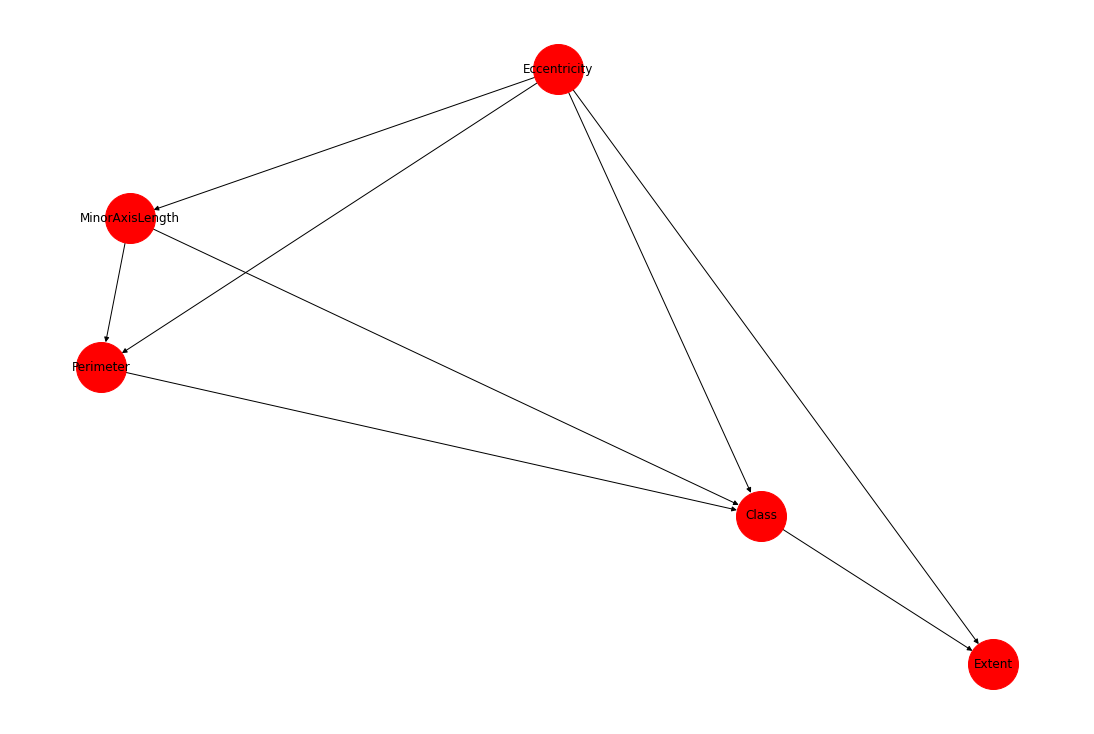

In [29]:
pos = graphviz_layout(model, prog="dot")
plt.figure(figsize=(15, 10))
nx.draw(model, with_labels=True, pos=pos, node_size=2500, node_color="red")
# plt.savefig('model.png')
plt.show()
